In [1225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import cluster, metrics # these will be useful
from sklearn import decomposition, metrics # these will be useful
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
def html_format2(*args):
    html_code = "<div style='display: flex;'>"
    
    for item in args:
        if isinstance(item, pd.DataFrame):
            html_code += f"<div style='flex: 1; padding: 5px;'>{item.to_html()}</div>"
        elif isinstance(item, plt.Figure):
            html_code += f"<div style='flex: 1; padding: 5px;'>{item._repr_html_()}</div>"
        else:
            raise ValueError("Unsupported input type. Only DataFrames and Matplotlib Figures are supported.")
    
    html_code += "</div>"
    
    display(HTML(html_code))

def html_format(*args):
    html_code = "<div style='display: flex; flex-wrap: wrap;'>"
    
    for item in args:
        if isinstance(item, pd.DataFrame):
            html_code += f"<div style='flex: 1; padding: 10px; overflow-x: auto;'>{item.to_html()}</div>"
        elif isinstance(item, plt.Figure):
            html_code += f"<div style='flex: 1; padding: 10px;'>{item._repr_html_()}</div>"
        else:
            raise ValueError("Unsupported input type. Only DataFrames and Matplotlib Figures are supported.")
    
    html_code += "</div>"
    
    display(HTML(html_code))
    

# read in the data
folder_path="C:/Users/jason/OneDrive/Desktop/MS Beng/Neatlabs/PERMA_pipeline/completed_analysis/Clustering"
shap_df = pd.read_csv(folder_path+"/shap_values.csv",index_col=0).iloc[:,:-2].drop(['perma8'],axis=1)
shap_direction_df = pd.read_csv(folder_path+"/shap_values_direction.csv",index_col=0).iloc[:,:-2].drop(['perma8'],axis=1)
corr_df = pd.read_csv(folder_path+"/corr_values.csv",index_col=0).iloc[:,:-2].drop(['perma8'],axis=1)
mindlog_df=pd.read_csv(folder_path+"/mindlog_mean.csv",index_col=0).iloc[:,:-2].drop(['perma8'],axis=1)


sample_table = pd.read_excel("C:/Users/jason/OneDrive/Desktop/MS Beng/Neatlabs/PERMA_pipeline/completed_analysis/redcaps/perma_completed_redcap(Sept26).xlsx",
                             sheet_name = 'phq9',
                            index_col=0)
sample_table=sample_table[0:38]

# gene_table = pd.read_excel(file_name,
#                            sheet_name = 'Gene Information',
#                            index_col = 0)

In [1011]:
from sklearn.decomposition import PCA
import matplotlib.cm as cm
import sklearn

def PCA_kmeans(data_df,K,gene_list,ax=None,biplot=False):
    # compute PCA
    # data_norm was computed in section 1.2.1'
    # Data is form samples x genes
    # Technically not normalizing it right but it works better lol
    data_norm=pd.DataFrame(stats.zscore(data_df,axis=0),index=data_df.index,columns=data_df.columns)
    data_norm=data_norm.fillna(0)
    pca = sklearn.decomposition.PCA().fit(data_norm)

    # get the explained variance, which will be useful later
    exp_var = pca.explained_variance_ratio_
    cum_var = exp_var.cumsum()
    n_components = np.sum(cum_var <= 0.8) # N components to explain 80% Variance

    # get the two important matrices & label them in pandas
    pc_genes = pd.DataFrame(pca.components_,
                            columns = gene_list)
    pc_samples = pd.DataFrame(pca.transform(data_norm),
                              index = data_norm.index)

    data_pc=pc_samples.iloc[:,:n_components]

    # Create summary dataframes for both top PCs
    # first add their values from pc_genes
    pc1 = pc_genes.loc[0].to_frame('weight')
    pc2 = pc_genes.loc[1].to_frame('weight')

    # need the absolute values to sort by
    pc1['abs_weight'] = pc1.weight.abs()
    pc2['abs_weight'] = pc2.weight.abs()

    # sort and keep only the top 5
    pc1 = pc1.sort_values('abs_weight', ascending = False).iloc[0:1]
    pc2 = pc2.sort_values('abs_weight', ascending = False).iloc[0:1]

    # concatenate the gene table info
    #pc1 = pd.concat([pc1, gene_table.loc[pc1.index]], axis = 1)
    #pc2 = pd.concat([pc2, gene_table.loc[pc2.index]], axis = 1)

    # Outlier rejection
    stdev=data_pc[0].values.std()
    outlier=data_pc[0].values/stdev>2.5
    data_pc=data_pc[~outlier]

    kmeans = cluster.KMeans(K,random_state=0).fit(data_pc);
    lab = kmeans.labels_;
    cluster_labels = pd.Series(lab, index = data_pc.index);

    # get the unique clusters (supports naming if desired)
    unique_clusters = np.sort(cluster_labels.unique())

    # prepare a long list of colors
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan',
              'black', 'salmon', 'chocolate', 'orange', 'gold', 'lawngreen',
              'turquoise', 'steelblue', 'navy', 'violet', 'deeppink',
              'firebrick', 'sandybrown','olivedrab','darkgreen', 'aqua',
              'slategray', 'blue', 'fuschia', 'pink']

    # this code only runs if you have a ton of labels
    while len(colors) < len(cluster_labels.unique()):
        colors = colors + colors

    # make the plot
#     if ax is None:
#         fig, ax = plt.subplots()
#     ax.set_xlabel('PC1', fontsize = 16)
#     ax.set_ylabel('PC2', fontsize = 16)

#     # iterate through each cluster label
#     for clust, color in zip(unique_clusters, colors):

#         # get the samples of this cluster
#         samples = cluster_labels.index[cluster_labels == clust]

#         # add to plot
#         ax.scatter(data_pc.loc[samples, 0],
#                    data_pc.loc[samples, 1],
#                    label = clust, color = color)

#     # add legend
#     ax.legend(bbox_to_anchor = (1,1))
#     # add the labels, use the exp_var
#     ax.set_xlabel('PC1 (%.1f%%)'%(exp_var[0]*100), fontsize = 18)
#     ax.set_ylabel('PC2 (%.1f%%)'%(exp_var[1]*100), fontsize = 18)

    # add the arrows
    if biplot:
        # begin by getting the genes from 1.3.1
        arrows_to_make = pc1.index.append(pc2.index)

        # this would get crowded, so remove specific genes that overlap
        #arrows_to_make = arrows_to_make.drop(['b3361','b3519', 'b0948', 'b3411'])

        # arrow length variable extends arrows to help in interpreting the plot
        # text_scale determines how far text labels are from arrow tips (1 = on top of them)
        arrow_length = 500
        text_scale = 0.8

        # the place the arrows start is up to you, so you can move it out of the way
        start1 = 40
        start2 = 0.8

        # loop through each gene and add its arrow
        for g in arrows_to_make:
            # directions in PC1 and 2
            g_weight_pc1 = pc_genes.loc[0,g]
            g_weight_pc2 = pc_genes.loc[1,g]

            # lengthen arrow by a constant factor
            g_weight_pc1 = g_weight_pc1 * arrow_length
            g_weight_pc2 = g_weight_pc2 * arrow_length
            # add the arrow
            ax.arrow(start1, start2, g_weight_pc1, g_weight_pc2, head_width = 0.3)

            # add the gene's name to the plot
            g_name = g
            ax.text(start1 + (text_scale * g_weight_pc1),
                    start2 + (text_scale * g_weight_pc2), 
                    g_name)
    #         text_scale+=0.1
    #         text_scale+=max(max(g_weight_pc1))
    group_df=pd.DataFrame({"Cluster 0":data_pc[cluster_labels==0].index})
    for i in range(K-1):
        new_df=pd.DataFrame({"Cluster "+str(i+1):data_pc[cluster_labels==i+1].index})
        group_df=pd.concat([group_df,new_df],axis=1).replace(np.nan,'')

    # display
#     print('PC1:')
#     display(pc1)
#     print('PC2:')
#     display(pc2)
    
#     print('Elements a Cluster:')
    display(group_df)

    return pc1,pc2,cluster_labels,data_pc

def cluster_summary(cluster_labels,sample_table):
    myclusters=pd.DataFrame()
    clusternames=pd.DataFrame()
    for i in range(cluster_labels.max()+1):
        df1 = sample_table.loc[cluster_labels.index[cluster_labels==i],'intervention'].reset_index(drop=True).rename('cluster '+str(i))
        myclusters = pd.concat([myclusters, df1], axis=1).replace(np.nan,'')
        
        df2 = sample_table.loc[cluster_labels.index[cluster_labels==i]].index.to_series().reset_index(drop=True).rename('cluster '+str(i))
        clusternames = pd.concat([clusternames, df2], axis=1).replace(np.nan,'')
    return myclusters,clusternames

def getpc(data_df):
    data_norm=pd.DataFrame(stats.zscore(data_df,axis=0),index=data_df.index,columns=data_df.columns)
    data_norm=data_norm.fillna(0)
    pca = sklearn.decomposition.PCA().fit(data_norm)

    # get the explained variance, which will be useful later
    exp_var = pca.explained_variance_ratio_
    cum_var = exp_var.cumsum()
    n_components = np.sum(cum_var <= 0.8) # N components to explain 80% Variance

    pc_samples = pd.DataFrame(pca.transform(data_norm),
                              index = data_norm.index)

    data_pc=pc_samples.iloc[:,:n_components]
    return data_pc

In [996]:
def plot_silhouette(data, cluster_labels):    
    sc = metrics.silhouette_samples(data.T, cluster_labels)
    ss = metrics.silhouette_score(data.T, cluster_labels)
    N_clusters = cluster_labels.max() + 1
    y_lower = N_clusters
    fig, ax = plt.subplots(figsize=(8,6))
    
    colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple',
              'tab:brown','tab:pink','tab:gray','tab:olive', 'tab:cyan',
              'black', 'salmon', 'chocolate', 'orange', 'gold', 'lawngreen',
              'turquoise', 'steelblue', 'navy', 'violet', 'deeppink',
              'firebrick', 'sandybrown','olivedrab','darkgreen', 'aqua',
              'slategray', 'blue', 'fuschia', 'pink']
    
    for i  in range(N_clusters):
        cluster_sc=sc[cluster_labels==i]
        cluster_sc.sort()
        size_cluster_sc=cluster_sc.shape[0]
        y_upper=y_lower+size_cluster_sc
        y_idx=np.arange(y_lower,y_upper)
        ax.fill_betweenx(y_idx,cluster_sc,facecolor=colors[i], edgecolor=colors[i])
        ax.text(-0.15,y_lower+0.5*size_cluster_sc,str(i))
        y_lower=y_upper+1
    ax.yaxis.set_ticks([])
    ax.set_xlim([-0.1,1])
    ax.set_title('Silhouette Plot')
    ax.set_ylabel('Cluster')
    ax.yaxis.set_label_coords(-0.07,0.5)
    ax.set_xlabel('Coefficient')
    
    # Return the generated figure
    return fig

In [1200]:
 def best_N_kmeans(mdl,data,N): 
    # Data is in the form of N subjects x N variables
    # Finding the best number of clusters for the model and data set
    ss_vect=np.zeros(N)
    for i in range(N):        
        kmeans = mdl.set_params(n_clusters=i+2).fit(data)
        cluster_labels=pd.Series(kmeans.labels_,data.index)
        ss_vect[i]=metrics.silhouette_score(data,cluster_labels)
        
#     plt.plot(np.arange(N)+1,ss_vect)
#     plt.title(str(max(ss_vect)))
#     plt.xlabel('N clusters')
#     plt.ylabel('Silhouette Score')
    return ss_vectr

 def best_N_gm(mdl,data,N): 
    # Data is in the form of N subjects x N variables
    # Finding the best number of clusters for the model and data set
    ss_vect=np.zeros(N)
    bic=np.zeros(N)
    for i in range(N):        
        gm = mdl.set_params(n_components=i+2).fit(data)
        labels=gm.predict(data)
        cluster_labels=pd.Series(labels,data.index)
        ss_vect[i]=metrics.silhouette_score(data,cluster_labels)
        bic[i] = gm.bic(data)
        
        
        
#     plt.plot(np.arange(N)+1,ss_vect)
#     plt.title(str(max(ss_vect)))
#     plt.xlabel('N clusters')
#     plt.ylabel('Silhouette Score')
    return ss_vect,bic

# Creating datasets

In [1198]:
shap_norm = shap_df.fillna(0).div(shap_df.fillna(0).sum()).T
shap_d_norm = shap_direction_df.fillna(0).div(shap_df.fillna(0).sum()).T
shap_common = shap_df.dropna(axis='index').T
shap_direct_common=shap_direction_df.dropna(axis='index').T
corr_norm=corr_df.fillna(0).T
corr_common=corr_df.dropna().T

shap_norm_noA= shap_df.fillna(0).div(shap_df.fillna(0).sum()).drop(index=['Mood_anxious']).T
shap_d_norm_noA = shap_direction_df.fillna(0).div(shap_df.fillna(0).sum()).drop(index=['Mood_anxious']).T
shap_common_noA = shap_df.dropna(axis='index').drop(index=['Mood_anxious']).T
shap_direct_common_noA=shap_direction_df.dropna(axis='index').drop(index=['Mood_anxious']).T
corr_norm_noA=corr_df.fillna(0).drop(index=['Mood_anxious']).T
corr_common_noA=corr_df.dropna().drop(index=['Mood_anxious']).T

shap_d_pc_noA=getpc(shap_direction_df.drop(index=['Mood_anxious']).T)
shap_pc_noA=getpc(shap_df.drop(index=['Mood_anxious']).T)
shap_d_pc=getpc(shap_direction_df.T)
shap_pc=getpc(shap_df.T)

corr_pc_noA=getpc(corr_df.drop(index=['Mood_anxious']).T)
corr_pc=getpc(corr_df.T)

raw_data=mindlog_df.drop(index=['Mood_anxious','Mood_depressed'])
mindlog=stats.zscore(raw_data,nan_policy='omit',axis=1).replace(np.nan,0).T
mindlog_pc=getpc(mindlog_df.T)


variable_names = [
    'shap_norm', 'shap_d_norm', 'shap_common', 'shap_direct_common', 
    'corr_norm', 'corr_common', 'shap_norm_noA', 'shap_d_norm_noA', 
    'shap_common_noA', 'shap_direct_common_noA', 'corr_norm_noA', 
    'corr_common_noA', 'shap_d_pc_noA', 'shap_pc_noA', 'shap_d_pc', 'shap_pc', 
    'corr_pc_noA', 'corr_pc','mindlog','mindlog_pc'
]

variables = [
    shap_norm, shap_d_norm, shap_common, shap_direct_common, 
    corr_norm, corr_common, shap_norm_noA, shap_d_norm_noA, 
    shap_common_noA, shap_direct_common_noA, corr_norm_noA, 
    corr_common_noA, shap_d_pc_noA, shap_pc_noA, shap_d_pc, shap_pc, 
    corr_pc_noA, corr_pc,mindlog,mindlog_pc
]

# Create a dictionary using a dictionary comprehension
data_dict = {var_name: var for var_name, var in zip(variable_names, variables)}


In [1182]:
def rm_outlier(data_df):
    outlier_count=1;
    while outlier_count>0:
        data_pc=getpc(data_df)
        # Outlier rejection
        stdev=data_pc.iloc[:,0:2].values.std(axis=0)
        outlier=data_pc.iloc[:,0:2].values/stdev>2.5
        data_df=data_df[outlier.sum(axis=1)==0]
        outlier_count=outlier.sum()
    
    return data_df

In [1263]:
data_dict['mindlog']

,Sleep_bedtime,Sleep_wakeuptime,Sleep_duration,Sleep_percent,Sleep_naptime,Sleep_satisfaction,Exercise_satisfaction,Diet_satisfaction,Connect_chatpeople,Connect_chattime,...,Connect_volunteertime,past_day_caffeine,heart_rate,cumm_step_count,cumm_step_calorie,cumm_step_speed,cumm_step_distance,exercise_calorie,exercise_duration,past_day_exercise_strenuous
perma1,-1.783839,0.201264,-1.171472,0.502773,-0.801337,0.213755,-0.643343,-0.114445,0.803580,0.551233,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
perma2,1.025082,-0.144823,0.045417,-0.183336,-0.859738,1.287335,1.550361,1.602895,0.401481,0.716120,...,-0.962080,-0.149410,-0.837933,0.499109,0.170124,-0.235542,0.461375,0.263007,0.803489,0.000000
perma4,-0.307563,1.255072,1.799669,-1.570277,-0.621268,-0.829690,-0.668118,-0.796566,0.029282,-0.193967,...,0.000000,-0.502511,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.119053
perma5,0.942897,-0.034349,1.456228,0.493687,-0.561894,0.376675,-0.932229,-1.220819,-0.127949,0.616272,...,0.000000,0.133949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
perma6,0.230978,0.417751,1.440213,-0.395293,0.000000,-1.083244,-1.160416,-0.610885,-1.143986,-1.096694,...,0.000000,-0.933364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
perma9,0.342192,-2.975775,-0.214148,-2.506705,0.000000,-0.446717,0.241595,-0.127553,0.375190,-0.459390,...,0.000000,0.446597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
perma10,-0.638519,0.068960,-1.081814,-1.653522,0.000000,-1.519041,1.469883,1.020474,-1.250951,-1.433239,...,-1.383336,2.709317,0.520523,-1.312441,-1.373440,-0.297218,-1.357043,-1.067332,-1.118990,0.000000
perma13,-1.507107,3.862878,0.406946,0.239104,-0.663678,0.327436,1.676386,1.598596,2.214792,1.079265,...,0.000000,-0.964304,-1.111731,-0.962414,-0.696123,1.385711,-0.939563,-0.606520,-0.876761,0.000000
perma14,0.973703,0.319440,0.851558,-0.935235,0.191478,-0.633809,-0.614478,-0.595942,-0.804815,-1.001457,...,1.905698,0.026317,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
perma16,-0.045103,0.089419,-0.035197,0.418184,0.016275,0.948310,0.020541,0.976948,1.669638,0.029089,...,0.214444,-0.632659,0.578526,-0.807898,-0.837826,1.014593,-0.769330,0.000000,0.000000,0.000000


# Finding best model and dataset

In [1199]:
km=cluster.KMeans(random_state=42)
N=5
results_df = pd.DataFrame(columns=np.arange(N)+1, index=data_dict.keys())


for var_name,data_df in data_dict.items():
    
    data_df=rm_outlier(data_df)
    ss_vect = best_N_kmeans(km, data_df, N)
    results_df.loc[var_name] = ss_vect

results_df

,1,2,3,4,5
shap_norm,0.326607,0.326462,0.278223,0.261447,0.256147
shap_d_norm,0.612682,0.272977,0.241675,0.170612,0.198065
shap_common,0.54969,0.529768,0.515843,0.495691,0.477952
shap_direct_common,0.886339,0.733513,0.598726,0.368021,0.287283
corr_norm,0.168624,0.125359,0.057464,0.066237,0.070675
corr_common,0.151631,0.204086,0.131078,0.132893,0.114302
shap_norm_noA,0.506986,0.282158,0.261679,0.1778,0.1755
shap_d_norm_noA,0.436811,0.352428,0.248654,0.194931,0.117862
shap_common_noA,0.306879,0.303387,0.312959,0.32897,0.347812
shap_direct_common_noA,0.718456,0.322002,0.330608,0.335403,0.315501


In [1216]:
gm=GaussianMixture(random_state=0,init_params='random')
N=10
gm_results_df = pd.DataFrame(columns=np.arange(N)+1, index=data_dict.keys())
gm_bic_df = pd.DataFrame(columns=np.arange(N)+1, index=data_dict.keys())

for var_name,data_df in data_dict.items():
    #data_df=rm_outlier(data_df)
    ss_vect,bic = best_N_gm(gm, data_df, N)
    gm_results_df.loc[var_name] = ss_vect
    gm_bic_df.loc[var_name] = bic



In [1220]:
df=gm_bic_df
df #6 shap common no A

,1,2,3,4,5,6,7,8,9,10
shap_norm,-4719.159536,-4011.656332,-2701.233088,-837.634589,731.79564,2591.482617,4615.830463,6707.63763,8683.160223,10664.035089
shap_d_norm,-5959.489758,-4812.17731,-3276.364629,-1399.360485,361.48274,2265.005284,4329.195833,6374.86182,8386.419954,10358.646036
shap_common,2583.292259,1446.197413,1489.682628,522.209457,129.847752,713.979195,338.55001,779.18097,826.845703,769.554989
shap_direct_common,1323.215609,470.430308,238.523833,-452.100419,-230.200097,-381.223764,-194.154966,41.843926,49.795006,624.936249
corr_norm,-2977.660985,-2856.779507,-1926.461065,-72.60419,1265.691262,3032.814266,5193.695095,7184.493098,9032.708642,10957.040812
corr_common,-76.114102,-235.572569,-380.431971,-746.650698,-776.035109,-774.120565,-799.610678,-470.436799,-494.962965,-343.472487
shap_norm_noA,-4654.022911,-4052.335923,-2851.336021,-1101.507273,356.920956,2098.378366,4007.229587,6024.032465,7837.205266,9698.392384
shap_d_norm_noA,-6027.617181,-4934.207595,-3435.64527,-1726.226884,-29.843282,1825.860865,3746.581381,5636.217189,7559.797248,9407.894635
shap_common_noA,2242.03841,1333.115919,1207.818324,671.840073,51.427676,686.111714,257.505935,433.24348,465.073792,470.616331
shap_direct_common_noA,1008.45936,349.567644,159.570887,-385.725019,-456.327938,-211.010761,-163.487998,-290.127668,-144.393979,690.483523


In [1]:
df['mindlog_pc']

NameError: name 'df' is not defined

In [1132]:
results_df

,1,2,3,4,5
shap_norm,0.365044,0.387082,0.358563,0.347967,0.343107
shap_d_norm,0.782421,0.724201,0.746477,0.419215,0.397807
shap_common,0.562385,0.511293,0.475976,0.527082,0.550315
shap_direct_common,0.812088,0.658464,0.698789,0.743255,0.474152
corr_norm,0.177581,0.180274,0.187182,0.228296,0.236122
corr_common,0.191836,0.251322,0.247653,0.247121,0.269193
shap_norm_noA,0.531021,0.333205,0.250335,0.245622,0.268456
shap_d_norm_noA,0.843,0.777363,0.420715,0.454557,0.263696
shap_common_noA,0.765681,0.782821,0.796425,0.577363,0.476758
shap_direct_common_noA,0.760656,0.782488,0.517373,0.462261,0.511273


In [1169]:
data_df=data_dict['shap_d_norm_noA']
data_pc=getpc(data_df)
# Outlier rejection
stdev=data_pc.iloc[:,0:2].values.std(axis=0)
outlier=data_pc.iloc[:,0:2].values/stdev>2.5
data_pc=data_pc[outlier.sum(axis=1)==0]


In [1223]:
data_df

,Sleep_wakeuptime,Diet_satisfaction,past_day_exercise_mild,Breath_response,Sleep_bedtime,Reflect_totaltime,Exercise_satisfaction,Reflect_activetime,Sleep_duration,time_of_day,...,exercise_duration,exercise_calorie,cumm_step_count,cumm_step_calorie,past_day_caffeine,cumm_step_distance,heart_rate,cumm_step_speed,Connect_volunteertime,past_day_exercise_strenuous
perma1,7.298168e-02,0.003517,0.003154,0.001127,0.001098,0.001023,0.000851,6.674128e-04,0.000580,0.000239,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000
perma4,1.261765e-03,-0.001110,-0.014739,0.001376,-0.020189,-0.003794,0.002779,-2.159410e-03,0.004359,0.000816,...,0.0,0.0,0.0,0.0,0.001614,0.0,0.0,0.0,0.0,0.000865
perma5,9.328851e-03,0.001512,0.005462,-0.004733,0.000333,-0.005102,-0.004272,2.246571e-03,0.007053,0.000239,...,0.0,0.0,0.0,0.0,0.000080,0.0,0.0,0.0,0.0,0.000000
perma9,1.173055e-02,0.000415,-0.000914,0.016200,0.000478,-0.006725,0.003555,8.283303e-03,0.001457,-0.000441,...,0.0,0.0,0.0,0.0,-0.006121,0.0,0.0,0.0,0.0,0.000000
perma19,2.377704e-03,0.011046,0.000129,-0.001762,-0.010426,0.000000,0.001041,0.000000e+00,0.017073,0.003038,...,0.0,0.0,0.0,0.0,-0.005552,0.0,0.0,0.0,0.0,0.020705
perma22,-1.546987e-03,0.004884,-0.002293,0.002669,0.005090,-0.000772,0.004938,1.062823e-03,0.004153,-0.003694,...,0.0,0.0,0.0,0.0,-0.003724,0.0,0.0,0.0,0.0,0.003930
perma23,0.000000e+00,0.000000,-0.105260,0.000000,-0.004278,0.000000,0.000000,0.000000e+00,0.000000,0.007265,...,0.0,0.0,0.0,0.0,0.033207,0.0,0.0,0.0,0.0,0.000000
perma24,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.002126,...,0.0,0.0,0.0,0.0,0.000406,0.0,0.0,0.0,0.0,-0.027595
perma36,-6.690201e-19,-0.001973,0.026950,0.000000,0.014396,0.000000,-0.016697,4.062724e-04,0.000000,0.004090,...,0.0,0.0,0.0,0.0,-0.001865,0.0,0.0,0.0,0.0,0.000000
perma37,-4.690507e-05,0.002188,-0.004201,0.000086,0.000072,0.002295,0.000665,2.259325e-03,0.000430,0.088193,...,0.0,0.0,0.0,0.0,-0.000196,0.0,0.0,0.0,0.0,0.000000


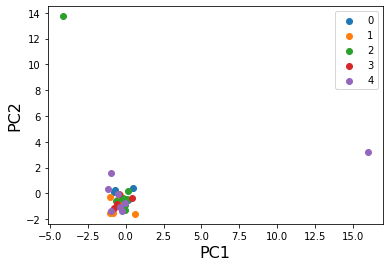

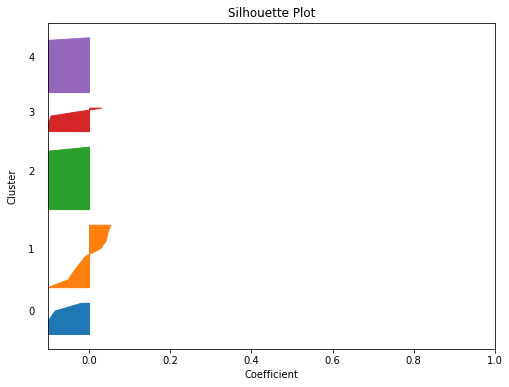

In [1255]:
data_df=data_dict['shap_d_norm_noA']

#data_df=rm_outlier(data_df)

N_clusters=5

gm=GaussianMixture(n_components=N_clusters,random_state=0,init_params='random')

labels=gm.fit_predict(data_df)
prob=gm.predict_proba(data_df)
cluster_labels=pd.Series(labels,data_df.index)

PCA_cluster_plot(data_df.T, cluster_labels, ax = None)
#myclusters,clusternames = cluster_summary(cluster_labels,sample_table)
fig = plot_silhouette(data_df.T,cluster_labels)

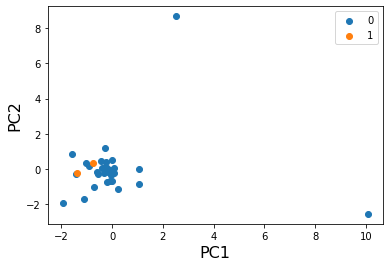

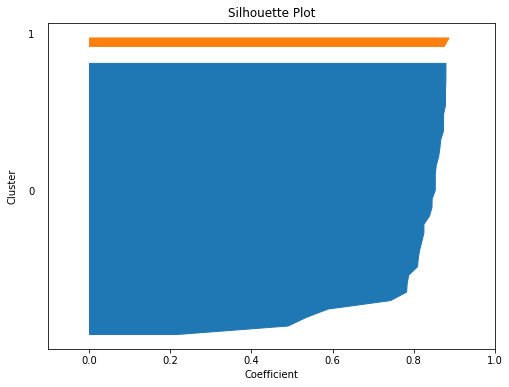

In [1252]:

data_df=data_dict['shap_direct_common']

#data_df=rm_outlier(data_df)
    
N_clusters=2
kmeans=cluster.KMeans(n_clusters=N_clusters,random_state=42).fit(data_df)
cluster_labels=pd.Series(kmeans.labels_,data_df.index)
#cluster_labels.index.equals(data.columns)
PCA_cluster_plot(data_df.T, cluster_labels, ax = None)
#myclusters,clusternames = cluster_summary(cluster_labels,sample_table)
fig = plot_silhouette(data_df.T,cluster_labels)


# TSNE

In [1259]:
### Figuring out best dataset
divergence=pd.DataFrame(columns=['divergence'])
for var_name,data_df in data_dict.items():
    tsne = TSNE(n_components=3, random_state=42)
    X_tsne = tsne.fit_transform(data_df)
    divergence.loc[var_name]=tsne.kl_divergence_
divergence
    

,divergence
shap_norm,0.692564
shap_d_norm,0.716903
shap_common,0.693816
shap_direct_common,1.282910
corr_norm,0.920836
corr_common,0.991130
shap_norm_noA,0.821631
shap_d_norm_noA,1.603404
shap_common_noA,1.733562
shap_direct_common_noA,1.341234


In [1257]:
import plotly.express as px
tsne = TSNE(n_components=2, random_state=42)

data_df=data_dict['shap_direct_common']
X_tsne = tsne.fit_transform(data_df)
y=cluster_labels


divergence.loc[var_name]=tsne.kl_divergence_
fig = px.scatter(x=X_tsne[:, 0], y=X_tsne[:, 1], color=y)
fig.update_layout(
    title="t-SNE visualization of Custom Classification dataset",
    xaxis_title="First t-SNE",
    yaxis_title="Second t-SNE",
)
fig.show()

In [1028]:
# data_df=shap_direction_df.T
# #data_df=data_df.drop(columns=['Mood_anxious'])
# #data_df=data_df.dropna(axis=1)

# K=4
# (pc1,pc2,cluster_labels,data_pc) = PCA_kmeans(data_df,K,data_df.columns.to_list(),ax=None,biplot=False)
# cluster_summary(cluster_labels,sample_table)

In [1029]:
# N_clusters=6
# kmeans=cluster.KMeans(n_clusters=N_clusters,random_state=42).fit(data.T)
# cluster_labels=pd.Series(kmeans.labels_,data.columns)
# #cluster_labels.index.equals(data.columns)
# #PCA_cluster_plot(data, cluster_labels, ax = None)
# cluster_summary(cluster_labels,sample_table)

In [1030]:
#sample_table.loc[cluster_labels.index[cluster_labels==2]] # Getting sample table of just those in one cluster

# Mixture Models

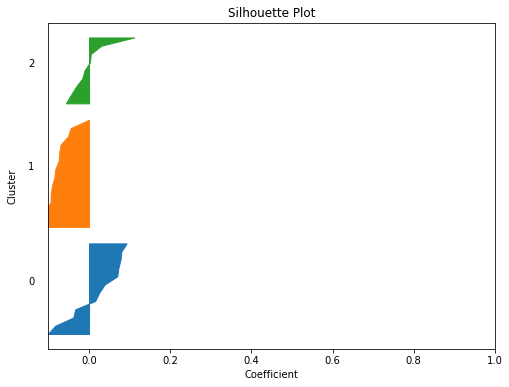

In [1009]:
from sklearn.mixture import GaussianMixture



### independent Corr data + PCA
raw_data=corr_df.drop(index=['Mood_anxious']).T
data_pc=getpc(raw_data)
data_pc=raw_data.replace(np.nan,0)


### Shap data
# raw_data=shap_direction_df.drop(index=['Mood_anxious'])
# data_pc=raw_data.replace(np.nan,0)
# data_pc=(data_pc/data_pc.sum()).T
#data_pc=stats.zscore(raw_data,nan_policy='omit',axis=1).replace(np.nan,0).T
#data_pc=getpc(raw_data.T)

### Only using complete variables
# newraw = raw_data/raw_data.sum()
# data = newraw.dropna(axis='index')

### Only keeping high impact variables
# data=raw_data.replace(np.nan,0)
# data=data/data.sum()
# data = data.loc[data.abs().max(axis=1)>0.4,:]

### Mindlog Avg data
# raw_data=mindlog_df.drop(index=['Mood_anxious','Mood_depressed'])
# data_pc=raw_data.replace(np.nan,0).T
# data_pc=data_pc/data_pc.sum()
# data_pc=stats.zscore(raw_data,nan_policy='omit',axis=1).replace(np.nan,0).T


n_c=3
gm=GaussianMixture(n_components=n_c,random_state=0,init_params='random')

labels=gm.fit_predict(data_pc)
prob=gm.predict_proba(data_pc)
cluster_labels=pd.Series(labels,data_pc.index)
(myclusters,clusternames)=cluster_summary(cluster_labels,sample_table)
#display(myclusters)
#display(clusternames)
fig = plot_silhouette(data_pc.T,cluster_labels)

#html_format(fig,myclusters)

In [633]:
# ss_vect=np.zeros(5)
# for i in range(5):
#     kmeans=cluster.KMeans(n_clusters=i+2,random_state=0).fit(data.T)
#     cluster_labels=pd.Series(kmeans.labels_,data.columns)
#     ss_vect[i]=metrics.silhouette_score(data.T,cluster_labels)
# plt.plot(ss_vect)
# plt.title('Silhouette Score Across clusters')
# plt.xlabel('N clusters')
# plt.ylabel('Silhouette Score')
# #plt.vlines(21,0,0.41,color='red',label="n=20")

In [634]:
# linkage_type=['single','complete','average']

# for link in linkage_type:
    
#     model=cluster.AgglomerativeClustering(distance_threshold=0,n_clusters=None,linkage=link).fit(data.T)
#     Dendrogram=hierarchy.linkage(model.children_,link)
#     plt.figure(figsize=(20,10))
#     sd=hierarchy.dendrogram(Dendrogram)
#     plt.title(link+' linkage Dendrogram')
#     plt.ylabel('Distances')
#     plt.xlabel('Condition')
#     plt.show()

In [453]:
n_c=3
model=cluster.AgglomerativeClustering(n_clusters=n_c,linkage='ward').fit(data.T)
Dendrogram=hierarchy.linkage(model.children_,link)
cluster_labels=pd.Series(model.labels_,data.columns)
#plt.figure(figsize=(20,10))
#sd=hierarchy.dendrogram(Dendrogram)
#model.labels_
#PCA_cluster_plot(data, cluster_labels, ax = None)
#plt.title(str(n_c)+' Clusters')
cluster_summary(cluster_labels,sample_table)

,cluster 0,cluster 1,cluster 2
0,Sleep,Positivity,Exercise
1,Sleep,Exercise+Diet,Positivity
2,Sleep,Positivity,Positivity
3,Positivity,Positivity,Positivity
4,Diet+Exercise,Exercise,Diet
5,Positivity,,Positivity
6,Diet,,Positive/Exercise
7,Sleep,,Exercise
8,Positivity,,Positivity
9,,,Sleep


# PCA

We need 10 PC components to explain 80% of the variance


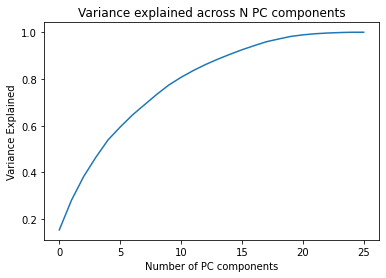

In [354]:
norm_df=stats.zscore(data,axis=1)
pca=decomposition.PCA() # create 102 dim PCA decomp
pca.fit(norm_df.T)                       # Fit the Data
principalComponents=pca.transform(norm_df.T)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xlabel('Number of PC components')
plt.ylabel('Variance Explained')
plt.title('Variance explained across N PC components')
min_n=np.where(pca.explained_variance_ratio_.cumsum()>0.8)[0][0]
print('We need '+str(min_n)+' PC components to explain 80% of the variance')


# ICA

In [355]:
n_keep=24
ica=decomposition.FastICA(n_components=n_keep,random_state=0) # N_components from PCA to keep 95% variance
ica=ica.fit(norm_df.T)
A=pd.DataFrame(ica.transform(norm_df.T),index=data.columns)
M=pd.DataFrame(ica.mixing_, index=data.index)
ica_reconstructed=np.dot(A,M.T).T


metrics.explained_variance_score(norm_df,ica_reconstructed)

C:\Users\jason\anaconda3\lib\site-packages\sklearn\decomposition\_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


0.9969756028717145

In [ ]:
uses_fructose=sample_table['Carbon Source (g/L)']== 'fructose(2)'
fructose_samps=sample_table.index[uses_fructose]
fructose=sample_table.loc[fructose_samps,'Carbon Source (g/L)']
non_fructose=sample_table.index[sample_table['Carbon Source (g/L)']!= 'fructose(2)']

#A.loc[fructose_samps][i]
#A.loc[non_fructose][i]

i=1
mwy=[stats.mannwhitneyu(A.loc[fructose_samps][i],A.loc[non_fructose][i])[0] for i in range(A.shape[1])]
mwy_p=[stats.mannwhitneyu(A.loc[fructose_samps][i],A.loc[non_fructose][i])[1] for i in range(A.shape[1])]
tt=[stats.ttest_ind(A.loc[fructose_samps][i],A.loc[non_fructose][i])[0] for i in range(A.shape[1])]
tt_p=[stats.ttest_ind(A.loc[fructose_samps][i],A.loc[non_fructose][i])[1] for i in range(A.shape[1])]

# fig, ax = plt.subplots(figsize = (10, 10))
# ax.plot(mwy)
# ax2=ax.twinx()
# ax2.plot(mwy_p,color='r')

plt.plot(tt)
plt.title('Test Statistic')
plt.xlabel('N Components')
plt.show()
plt.plot(tt_p)
plt.title('P-value')
plt.xlabel('N Components')
plt.show()
fruc_idx=np.argmin(tt_p)
fruc_idx